**<center> Joaquin Peñuela Parra, Cristian Fernando Rodriguez Cruz <center>**
**<center> University of Los Andes <center>**
**<center> High Energy Physics Group: Phenomenology of Particles <center>**

In [1]:
import os
import sys
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "serif"

#!git clone https://github.com/Phenomenology-group-uniandes/Heatmap_Utilities.git
import nbimporter
sys.path.append(f'{os.getcwd()}/Heatmap_Utilities')
from Heatmap_Utilities.Main_Functions import smooth, plot_heatmap

In [2]:
path_statistical_preparation = os.path.join(os.path.dirname(os.getcwd()), '06_Statistical_Preparation')

In [3]:
def approx_global_sig(sig: np.array, bkg: np.array, N: float = 0.0) -> float:
    """
    Calculates the statistical significance of a signal over background in a given dataset using a modified version of
    the formula (S -N sqrt(B))/sqrt(S+B), where S is the number of signal events, B is the number of background events,
    and N is the expected number of background events in the signal region.

    Parameters:
    sig (np.array): 1D array containing the number of signal events in each bin of the dataset.
    bkg (np.array): 1D array containing the number of background events in each bin of the dataset.
    N (float): Expected number of background events in the signal region. Default value is 0.0.

    Returns:
    float: The statistical significance of the signal over background in the dataset.
    """

    # calculate weight factor w for each bin
    w = np.log(1. + sig/(bkg + 1e-9))

    # calculate intermediate quantities
    s_w = sig * w
    b_w = bkg * w
    s_ww = sig * w ** 2
    b_ww = bkg * w ** 2

    # calculate numerator and denominator of modified formula
    num = np.sum(s_w) - N * np.sqrt(np.sum(b_ww))
    den = np.sqrt(np.sum(s_ww + b_ww))

    # calculate statistical significance and return it
    return num / den

In [4]:
channels = ["hadronic_Tau_Tau", "hadronic_Tau_Tau_b", "hadronic_Tau_Tau_b_b", "semileptonic_Tau_Tau", "semileptonic_Tau_Tau_b", "semileptonic_Tau_Tau_b_b"]
Masses = ["1000", '1250', '1500', '1750', '2000', '2250', '2500']
signals = ['Lq_Lq', 'tau_Lq', 'tau_tau']
bkgs =  ['tbart', 'V+jets', 'stop', 'Diboson']
betards = ['wRHC', 'woRHC']

In [5]:
Significances = {}

In [6]:
#sLQ, dLQ, non-res:

for betard in betards:
    Significances[betard] = {}
    folder_txt_files = f'{path_statistical_preparation}/txt_files_{betard}'

    for signal in signals:

        KFactors_Matrix = pd.read_excel(f'{path_statistical_preparation}/KFactors_by_coupling/{betard}/{signal}.xlsx', index_col= 0)
        KFactors_Matrix.columns = [float(column) for column in KFactors_Matrix.columns]
        KFactors_Matrix.index = [float(idx) for idx in KFactors_Matrix.index]

        Significances[betard][signal] = {}
        for Mass in Masses:

            Significances[betard][signal][float(Mass)] = {} 

            Signal_Data_1_8 = np.loadtxt(os.path.join(folder_txt_files, f'M{Mass}', f"high_per_bin_{signal}.txt"))

            BKG_Data = np.zeros(66)
            for bkg in bkgs:
                path_to_txt = os.path.join(folder_txt_files, f'M{Mass}', f"high_per_bin_{bkg}.txt")
                BKG_Data += np.loadtxt(path_to_txt)                

            for coupling in KFactors_Matrix.index:
                Signal_Data = Signal_Data_1_8*KFactors_Matrix[float(Mass)][coupling]
                Significances[betard][signal][float(Mass)][coupling] = approx_global_sig(Signal_Data, BKG_Data)

In [7]:
#Combined:

for betard in betards:
    
    KFactors_Matrix_lq_lq = pd.read_excel(f'{path_statistical_preparation}/KFactors_by_coupling/{betard}/Lq_Lq.xlsx', index_col= 0)
    KFactors_Matrix_lq_lq.columns = [float(column) for column in KFactors_Matrix_lq_lq.columns]
    KFactors_Matrix_lq_lq.index = [float(idx) for idx in KFactors_Matrix_lq_lq.index]
    
    KFactors_Matrix_tau_lq = pd.read_excel(f'{path_statistical_preparation}/KFactors_by_coupling/{betard}/tau_Lq.xlsx', index_col= 0)
    KFactors_Matrix_tau_lq.columns = [float(column) for column in KFactors_Matrix_tau_lq.columns]
    KFactors_Matrix_tau_lq.index = [float(idx) for idx in KFactors_Matrix_tau_lq.index]
    
    KFactors_Matrix_tau_tau = pd.read_excel(f'{path_statistical_preparation}/KFactors_by_coupling/{betard}/tau_tau.xlsx', index_col= 0)
    KFactors_Matrix_tau_tau.columns = [float(column) for column in KFactors_Matrix_tau_tau.columns]
    KFactors_Matrix_tau_tau.index = [float(idx) for idx in KFactors_Matrix_tau_tau.index]
    
    KFactors_Matrix = {"Lq_Lq": KFactors_Matrix_lq_lq, "tau_Lq": KFactors_Matrix_tau_lq, "tau_tau": KFactors_Matrix_tau_tau}
    
    Significances[betard]['Combined'] = {}
    for Mass in Masses:

        Significances[betard]['Combined'][float(Mass)] = {} 

        Matrix_Signal = np.zeros([11,6])
        Matrix_BKG = np.zeros([11,6])
        for coupling in KFactors_Matrix["Lq_Lq"].index:
            for n, channel in enumerate(channels):
                for signal in signals:            
                    path_to_txt = os.path.join(f'{path_statistical_preparation}/Histograms_{betard}', f'M{Mass}', channel, f"high_per_bin_{signal}.txt")
                    Matrix_Signal[:, n] +=  np.loadtxt(path_to_txt)*KFactors_Matrix[signal][int(Mass)][coupling]

                for bkg in bkgs:
                    path_to_txt = os.path.join(f'{path_statistical_preparation}/Histograms_{betard}', f'M{Mass}', channel, f"high_per_bin_{bkg}.txt")
                    Matrix_BKG[:, n] += np.loadtxt(path_to_txt)                

            Signal_Data = np.asarray(Matrix_Signal.reshape((1,66)))
            BKG_Data = np.asarray(Matrix_BKG.reshape((1,66)))    
            Significances[betard]['Combined'][float(Mass)][coupling] = approx_global_sig(Signal_Data, BKG_Data)

In [8]:
# #Combined:
# for betard in betards:
#     Significances[betard]['Combined'] = {}
    
#     for Mass in Masses:
#         Significances[betard]['Combined'][float(Mass)] = {} 
        
#         for coupling in KFactors_Matrix.index:              
#             Significances[betard]['Combined'][float(Mass)][coupling] = np.sqrt(sum(np.asarray([Significances[betard][signal][float(Mass)][coupling] for signal in signals])**2))

In [9]:
# !rm -rf Significances/**

In [10]:
titulos_izquierda = {'Lq_Lq' : 'dLQ', 'tau_Lq' : 'sLQ', 'tau_tau' : 'non-res', 'Combined' : 'Combined'}

for betard in betards:
    for key in Significances[betard]:
        file_name = f'Significances/Significance_Table_13TeV_L137_{titulos_izquierda[key]}_combined_{betard}.csv'.replace('Combined', 'all')
        pd.DataFrame.from_dict(Significances[betard][key]).to_csv(file_name)

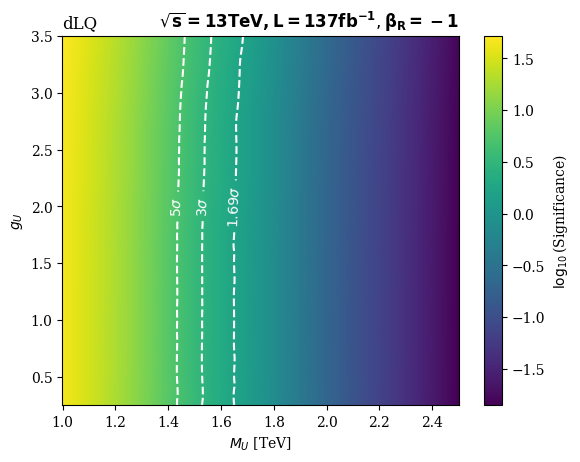

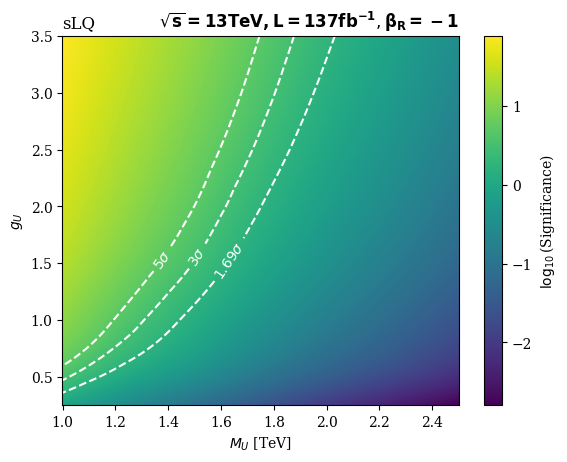

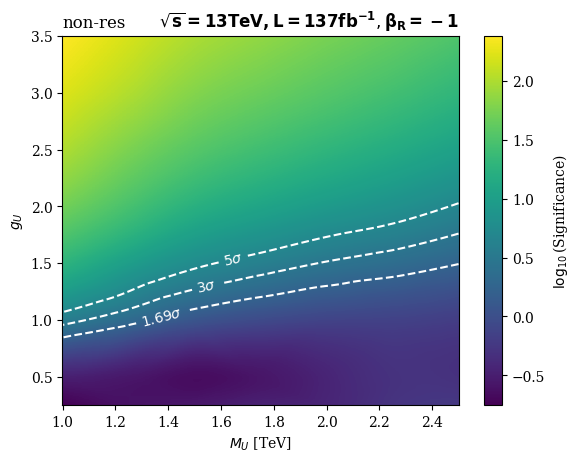

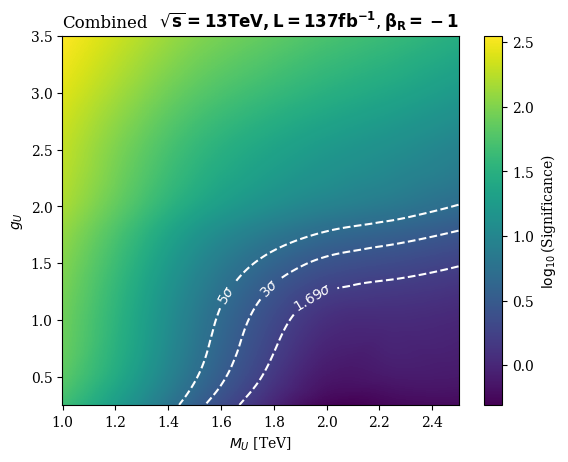

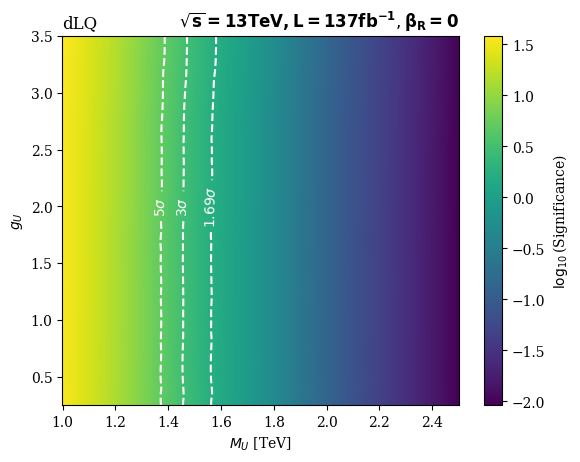

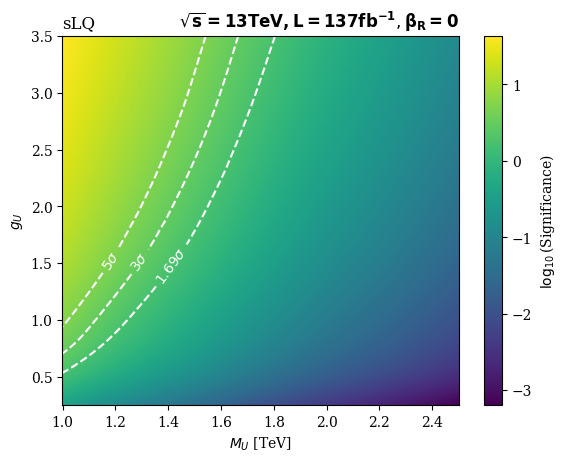

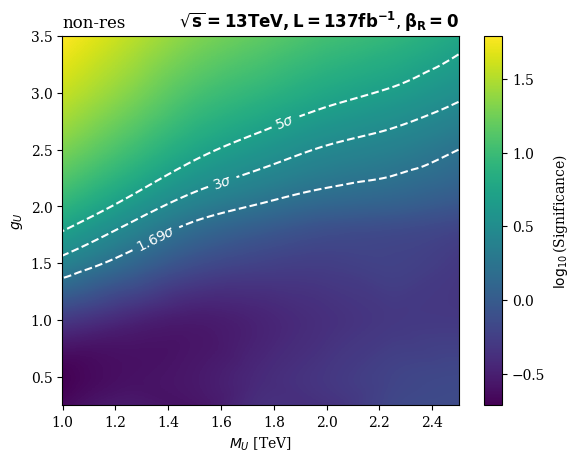

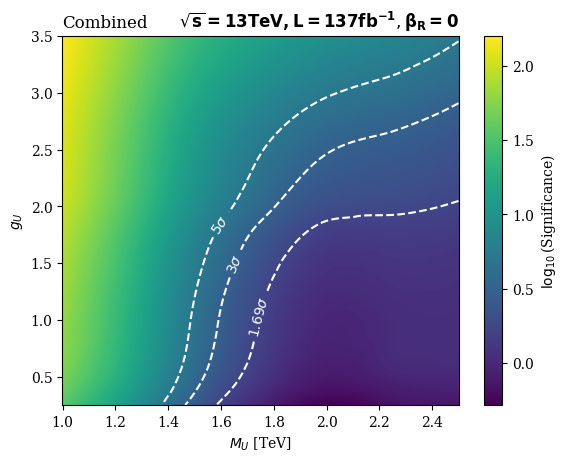

In [11]:
betard_title = {'wRHC': r'$, \mathbf{\beta_{R} = -1}$', 'woRHC': r'$, \mathbf{\beta_{R} = 0}$'}

ubicaciones = {'Lq_Lq_wRHC': [[1400/1000,2], [1550/1000, 2], [1650/1000, 2]],
               'tau_Lq_wRHC': [[1400/1000,1.5], [1550/1000, 1.5], [1650/1000, 1.5]], 
               'tau_tau_wRHC': [[1400/1000,0.8], [1550/1000, 1.25], [1650/1000, 1.5]], 
               'Combined_wRHC':[[1600/1000,1.25], [1800/1000, 1.25], [2000/1000, 1]],
               'Lq_Lq_woRHC': [[1400/1000,2], [1500/1000, 2], [1600/1000, 2]],
               'tau_Lq_woRHC': [[1200/1000,1.5], [1300/1000, 1.5], [1400/1000, 1.5]], 
               'tau_tau_woRHC': [[1400/1000,1.5], [1600/1000, 2.25], [1800/1000, 3]], 
               'Combined_woRHC':[[1500/1000,2], [1650/1000, 1.5], [1800/1000, 1]]
              }

# ubicaciones = {'Lq_Lq_wRHC': [[1400/1000,2], [1550/1000, 2], [1650/1000, 2]],
#                'tau_Lq_wRHC': [[1400/1000,1.5], [1550/1000, 1.5], [1650/1000, 1.5]], 
#                'tau_tau_wRHC': [[1400/1000,0.8], [1550/1000, 1.25], [1650/1000, 1.5]], 
#                'Combined_wRHC':[[1600/1000,1.25], [1900/1000, 1], [2000/1000, 0.5]],
#                'Lq_Lq_woRHC': [[1400/1000, 2], [1500/1000, 1.5], [1600/1000, 2]],
#                'tau_Lq_woRHC': [[1200/1000,1.5], [1300/1000, 1.5], [1400/1000, 1.5]], 
#                'tau_tau_woRHC': [[1400/1000,1.5], [1600/1000, 2.25], [1800/1000, 3]], 
#                'Combined_woRHC':[[1500/1000,2], [2000/1000, 1.5], [2000/1000, 0.5]]
#               }


def Calcular_g_U(c_U, M):
    v = 246
    return 2*np.sqrt(c_U)*M/v

for betard in betards:
    
    for key in Significances[betard]:
        Data = pd.DataFrame.from_dict(Significances[betard][key])
        Data.columns = [float(column)/1000 for column in Data.columns] #TeV
        
        Data_interpolate = smooth(Data, log = True)
        # Data_interpolate = np.log10(Data)
        
        fig, ax, curves = plot_heatmap(Data_interpolate,
                               curvas_de_nivel = {np.log10(1.69) : r'$1.69 \sigma$', np.log10(3): r'$3 \sigma$', np.log10(5): r'$5 \sigma$'},
                               curves_labels_locations= ubicaciones[f'{key}_{betard}'],
                               titulos = {'titulo':'','titulo_izquierda': titulos_izquierda[key],'titulo_derecha': r'$\mathbf{\sqrt{s} = 13 TeV, L = 137 fb^{-1}}$' + betard_title[betard] ,'x_label': r'$M_{U}$ [TeV]', 'y_label': r'$g_U$', 'cbar_label': r'$\log_{10}$(Significance)'}
                              )        

        #ax.set_xlim(1000/1000,2250/1000)
        
#         if betard == 'wRHC': c_u1, c_u2 = 0.006, 0.002
#         else:  c_u1, c_u2 = 0.017, 0.007
            
#         x = np.linspace(1000/1000, 2250/1000, 1000)

#         x_1, y_1 = 1000/1000, Calcular_g_U(c_u1, 1000)
#         x_2, y_2 = 2250/1000, Calcular_g_U(c_u1, 2250)

#         y1 = np.poly1d(np.polyfit([x_1,x_2], [y_1, y_2], deg=1))(x)

#         x_3, y_3 = 1000/1000, Calcular_g_U(c_u2, 1000)
#         x_4, y_4 = 2250/1000, Calcular_g_U(c_u2, 2250)

#         y2 = np.poly1d(np.polyfit([x_3,x_4], [y_3, y_4], deg=1))(x)

#         ax.plot(x, y1, c='black', alpha=0.5)
#         ax.plot(x, y2, c='black', alpha=0.5)

#         x = np.concatenate((x[0], x, x[-1]), axis = None)
#         y = np.concatenate((y2[0], y1, y2[-1]), axis = None)
#         ax.fill(x, y, 'gray', alpha=0.3, label = 'B anomalies')    
        # plt.legend()
        
        file_name = f'Significances/Significance_Heatmap_13TeV_L137_{titulos_izquierda[key]}_combined_{betard}.png'.replace('Combined', 'all')
        plt.savefig(file_name, bbox_inches='tight')

In [12]:
%%capture

sigma_curves = {}
for betard in betards:
    sigma_curves[betard] = {}
    
    for key in Significances[betard]:
        Data = pd.DataFrame.from_dict(Significances[betard][key])
        Data.columns = [float(column)/1000 for column in Data.columns] #TeV
        
        Data_interpolate = smooth(Data, log = True)
        
        fig, ax, sigma_curves[betard][key] = plot_heatmap(Data_interpolate,
                                       curvas_de_nivel = {np.log10(1.69) : '' , np.log10(3): '', np.log10(5): ''},
                                       curves_labels_locations= ubicaciones[f'{key}_{betard}'],
                                       titulos = {'titulo':'','titulo_izquierda': titulos_izquierda[key],'titulo_derecha': r'$\mathbf{\sqrt{s} = 13 TeV, L = 137 fb^{-1}}$' + betard_title[betard] ,'x_label': r'$M_{U}$ [TeV]', 'y_label': r'$g_U$', 'cbar_label': r'$\log_{10}$(Significance)'}
                                      )    

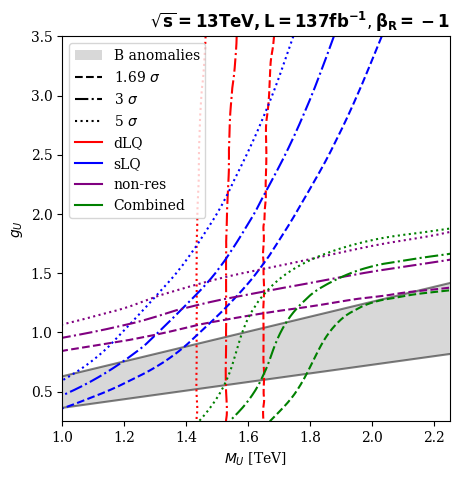

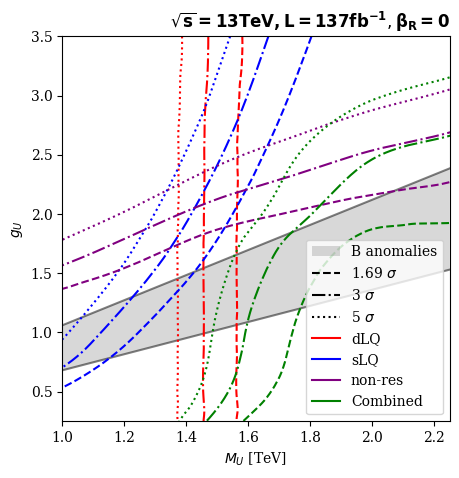

In [13]:
colors = {'Lq_Lq': 'red', 'tau_Lq': 'blue', 'tau_tau': 'purple', 'Combined': 'green'}

for betard in betards:    
    
    fig, ax = plt.subplots(figsize = (5,5))
    
    if betard == 'wRHC': c_u1, c_u2 = 0.006, 0.002
    else:  c_u1, c_u2 = 0.017, 0.007

    x = np.linspace(1000/1000, 2250/1000, 1000)

    x_1, y_1 = 1000/1000, Calcular_g_U(c_u1, 1000)
    x_2, y_2 = 2250/1000, Calcular_g_U(c_u1, 2250)

    y1 = np.poly1d(np.polyfit([x_1,x_2], [y_1, y_2], deg=1))(x)

    x_3, y_3 = 1000/1000, Calcular_g_U(c_u2, 1000)
    x_4, y_4 = 2250/1000, Calcular_g_U(c_u2, 2250)

    y2 = np.poly1d(np.polyfit([x_3,x_4], [y_3, y_4], deg=1))(x)

    ax.plot(x, y1, c='black', alpha=0.5)
    ax.plot(x, y2, c='black', alpha=0.5)

    x = np.concatenate((x[0], x, x[-1]), axis = None)
    y = np.concatenate((y2[0], y1, y2[-1]), axis = None)
    ax.fill(x, y, 'gray', alpha=0.3, label = 'B anomalies')  
    
    for n, key in enumerate(sigma_curves[betard]):
        
        curves = sigma_curves[betard][key]
        
        #Curva de 1.69 sigma
        x1 = np.concatenate([points.vertices[:,0] for points in curves.collections[0].get_paths()])
        y1 = np.concatenate([points.vertices[:,1] for points in curves.collections[0].get_paths()])

        #Curva de 3 sigma
        x2 = np.concatenate([points.vertices[:,0] for points in curves.collections[1].get_paths()])
        y2 = np.concatenate([points.vertices[:,1] for points in curves.collections[1].get_paths()])

        #Curva de 5 sigma
        x3 = np.concatenate([points.vertices[:,0] for points in curves.collections[2].get_paths()])
        y3 = np.concatenate([points.vertices[:,1] for points in curves.collections[2].get_paths()])
        
        if n == 0:
            plt.plot(0,0, label = r'1.69 $\sigma$', linestyle = 'dashed', c = 'black')
            plt.plot(0,0, label = r'3 $\sigma$', linestyle = 'dashdot', c = 'black')
            plt.plot(0,0, label = r'5 $\sigma$', linestyle = 'dotted', c = 'black')
            
        plt.plot(0,0, color = colors[key], label = titulos_izquierda[key])
        plt.plot(x1,y1, linestyle = 'dashed', color = colors[key])
        plt.plot(x2,y2, linestyle = 'dashdot', color = colors[key])
        plt.plot(x3,y3, linestyle = 'dotted', color = colors[key])    
        
    plt.legend()
    plt.xlim(1,2.25)
    plt.ylim(0.25,3.5)
    plt.title(r'$\mathbf{\sqrt{s} = 13 TeV, L = 137 fb^{-1}}$'+ betard_title[betard], loc = 'right')
    plt.xlabel(r'$M_{U}$ [TeV]')
    plt.ylabel(r'$g_U$')
    
    plt.savefig(f'Significances/Significance_Heatmap_13TeV_L137_summary_all_sigmas_{betard}.png', bbox_inches='tight')

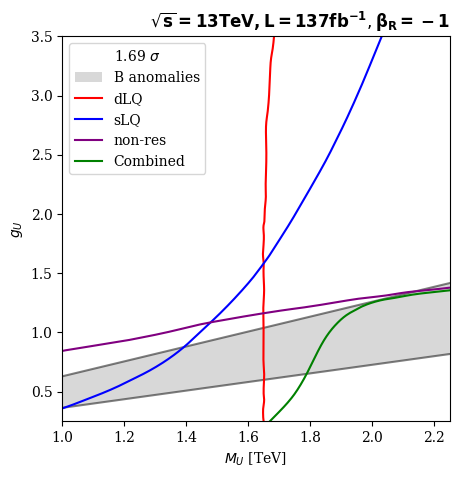

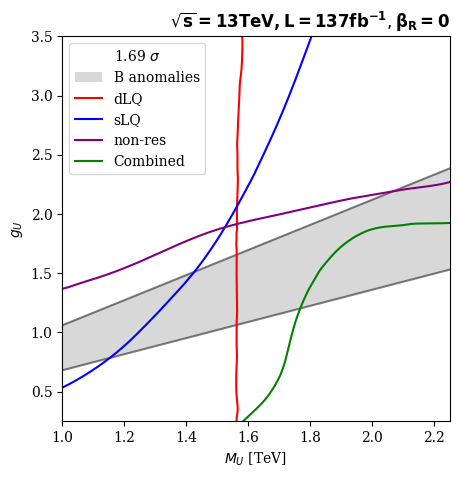

In [14]:
colors = {'Lq_Lq': 'red', 'tau_Lq': 'blue', 'tau_tau': 'purple', 'Combined': 'green'}

for betard in betards:    
    
    fig, ax = plt.subplots(figsize = (5,5))
    
    if betard == 'wRHC': c_u1, c_u2 = 0.006, 0.002
    else:  c_u1, c_u2 = 0.017, 0.007

    x = np.linspace(1000/1000, 2250/1000, 1000)

    x_1, y_1 = 1000/1000, Calcular_g_U(c_u1, 1000)
    x_2, y_2 = 2250/1000, Calcular_g_U(c_u1, 2250)

    y1 = np.poly1d(np.polyfit([x_1,x_2], [y_1, y_2], deg=1))(x)

    x_3, y_3 = 1000/1000, Calcular_g_U(c_u2, 1000)
    x_4, y_4 = 2250/1000, Calcular_g_U(c_u2, 2250)

    y2 = np.poly1d(np.polyfit([x_3,x_4], [y_3, y_4], deg=1))(x)

    ax.plot(x, y1, c='black', alpha=0.5)
    ax.plot(x, y2, c='black', alpha=0.5)

    x = np.concatenate((x[0], x, x[-1]), axis = None)
    y = np.concatenate((y2[0], y1, y2[-1]), axis = None)
    ax.fill(x, y, 'gray', alpha=0.3, label = 'B anomalies')  
    
    for n, key in enumerate(sigma_curves[betard]):
        
        curves = sigma_curves[betard][key]
        
        #Curva de 1.69 sigma
        x1 = np.concatenate([points.vertices[:,0] for points in curves.collections[0].get_paths()])
        y1 = np.concatenate([points.vertices[:,1] for points in curves.collections[0].get_paths()])
            
        plt.plot(0,0, color = colors[key], label = titulos_izquierda[key])
        plt.plot(x1,y1, linestyle = '-', color = colors[key])
    
        
    plt.legend(title = r'1.69 $\sigma$')
    plt.xlim(1,2.25)
    plt.ylim(0.25,3.5)
    plt.title(r'$\mathbf{\sqrt{s} = 13 TeV, L = 137 fb^{-1}}$'+ betard_title[betard], loc = 'right')
    plt.xlabel(r'$M_{U}$ [TeV]')
    plt.ylabel(r'$g_U$')
    
    plt.savefig(f'Significances/Significance_Heatmap_13TeV_L137_summary_sigma_1_69_{betard}.png', bbox_inches='tight')